In [1]:
import shap
import pandas as pd 
import sklearn
from scipy.spatial.distance import cosine
import numpy as np

ModuleNotFoundError: No module named 'shap'

In [ ]:

def cosineSimilarity(a, b):
    similarity = cosine(a, b) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    return similarity


def generateModel(dataset_path, XcolumnLabels, YcolumnLabels, model = sklearn.linear_model.LinearRegression()):
    """Generates a predictive task to input into the shapley value function. Takes dataset path, the column labels for the
    training (XcolumnLabels) and the prediction task (YcolumnLabels) data. The default model choice is a linear regression from sklearn.learn
    Also supports XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models."""
    data = pd.read_csv(dataset_path)

    #X = data[['date', 'time', 'latitude', 'longitude']] I'm not sure what the best model would be to pick for all 4 attributes
    X = data[XcolumnLabels]
    y = data[YcolumnLabels]

    # fit the model
    model.fit(X, y)
    return model, X


def ShapleyValue(model, X_features):
    #https://github.com/slundberg/shap #https://shap.readthedocs.io/en/latest/index.html 
 
    explainer = shap.Explainer(model.predict, X_features)
    shap_values = explainer(X_features)

    psi = shap_values.values #vector of the shapley values of each feature of each datapoint (the X_features).

    #print("shapley values", psi)
    shap.plots.beeswarm(shap_values)
    return psi

"""we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes 
over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. 
The color represents the feature value (red high, blue low). 
This reveals for example that a high latitude increases the predicted probability that the parking slot is empty."""

#dahleh paper would take the following inputs: ShapleyRobust(Y_n, X_M, K, SimilarityMeasure_Function, lambda):
def ShapleyRobust(model, X_features, SimilarityMeasure_Function, lamda):
    psi_n_bar = ShapleyValue(model, X_features)
    
    #initialising an empty array of the size of X_features to populate with the running sum of the Similarity Measure
    finalSimilarities = np.zeros(X_features.shape[0])

    for i,rowOfInterest in enumerate(np.array(X_features)): #rowOfInterest is the row we are comparing with all the rest of the rows in the Similarity Measure
        #every row needs to be compared against every other row, except itself, and calculate the SM.
        for row in np.array(X_features):

            if (rowOfInterest != row).all(): #checks all elements in the row
                finalSimilarities[i] += SimilarityMeasure_Function(rowOfInterest,row) #calculate the running sum of the SM of the rowOfInterest across all rows

    print('Similarity Measures\n', finalSimilarities.reshape(-1,1), '\n')
    ShapleyRobust = psi_n_bar* np.exp(-lamda * finalSimilarities.reshape(-1,1))
    return ShapleyRobust
    #Should subsample the similarity measure check, because currently its complexity is n similarity checks for n rows (so n^2)


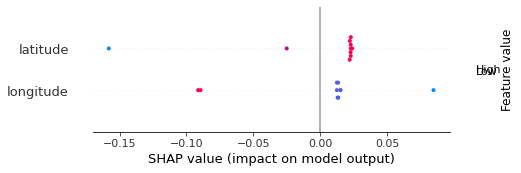

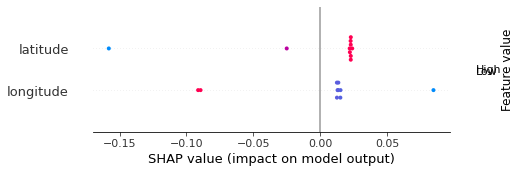

Similarity Measures
 [[0.00324032]
 [0.00324411]
 [0.01453789]
 [0.01029613]
 [0.00315683]
 [0.00319021]
 [0.01136156]
 [0.00315765]
 [0.00317163]
 [0.00318688]] 

SHAPLEY VALUES
 [[ 0.02297031  0.01516253]
 [ 0.0228241   0.01526993]
 [-0.15803472 -0.08940585]
 [ 0.02401107  0.08479162]
 [ 0.0222733   0.01256403]
 [ 0.02211499  0.01364807]
 [-0.02496448 -0.09123414]
 [ 0.02293892  0.012596  ]
 [ 0.02294214  0.01305877]
 [ 0.02292438  0.01354904]] 
 SHAPLEY Robust VALUES
 [[ 0.02289599  0.01511348]
 [ 0.02275017  0.01522048]
 [-0.15575385 -0.08811548]
 [ 0.02376512  0.08392307]
 [ 0.0222031   0.01252443]
 [ 0.02204455  0.0136046 ]
 [-0.02468245 -0.09020345]
 [ 0.0228666   0.01255629]
 [ 0.02286949  0.01301742]
 [ 0.02285144  0.01350593]]


In [ ]:
data = pd.read_csv("datapoints.csv")
TrainingColumnLabels = ['latitude', 'longitude']
PredictionColumnLabels = ['probability']
dataPath = "datapoints.csv"

LinearRegressionModel, X_features = generateModel(dataPath, TrainingColumnLabels, PredictionColumnLabels)

ShapleyValues = ShapleyValue(LinearRegressionModel, X_features)

ShapleyRobustValues = ShapleyRobust(LinearRegressionModel, X_features, cosineSimilarity, 1)

print('SHAPLEY VALUES\n', ShapleyValues, '\n', 'SHAPLEY Robust VALUES\n', ShapleyRobustValues)



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b81a959-51f8-469a-8dd7-054eee2b945d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>